In [1]:
import sys
sys.path.append("../classes")

import matplotlib.pyplot as plt
import numpy as np
import MNIST_data as mnist
import cnn_recogniser as CNN

%matplotlib inline

# Standard MNIST dataset

#### We load the MNIST dataset from our own created class. We extract training, validation and testing set.

In [24]:
MNIST = mnist.MNIST()
X, X_valid, X_test, y, y_valid, y_test = MNIST.learning_sets()

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


#### Reformatting for Recogniser_Type1 usage

In [25]:
X = X.reshape((-1, X.shape[1], X.shape[1],1))
X_valid = X_valid.reshape((-1, X_valid.shape[1], X_valid.shape[1],1))
X_test = X_test.reshape((-1, X_test.shape[1], X_test.shape[1],1))

y = np.argmax(y[:,0,:], 1)
y_test = np.argmax(y_test[:,0,:], 1)
y_valid = np.argmax(y_valid[:,0,:], 1)

yc = np.ones((len(y),2),dtype=np.int64)
yc_valid = np.ones((len(y_valid),2),dtype=np.int64)
yc_test = np.ones((len(y_test),2),dtype=np.int64)

yc[:,1] = y
yc_valid[:,1] = y_valid
yc_test[:,1] = y_test


print yc.shape, yc_valid.shape, yc_test.shape
print X.shape, X_valid.shape, X_test.shape

(55000, 2) (5000, 2) (10000, 2)
(55000, 28, 28, 1) (5000, 28, 28, 1) (10000, 28, 28, 1)


#### Here we build a convolutional network for our problem. The structure variable below defines how the network is structured. At the moment the API allows to fix the number of convolutional/maxpooling layers and their parameters. 

In [28]:
structure = [("conv", {"patch_x": 5, "patch_y": 5, "depth": 32, "channels" : 1}), ("pool", {"side": 2, "stride": 2, "pad": "SAME"}),
                 ("conv", {"patch_x": 5, "patch_y": 5, "depth": 64, "channels": 32}), ("pool", {"side": 2, "stride": 2, "pad": "SAME"})]

model = CNN.Recogniser_Type2(structure=structure, nb_classes=10, img_rows=28, img_cols=28, nb_hidden=512, max_nb_digits=1)

#### We fit the model with the training set (X, y). We fix the batch size to 128 instances, pass also the validation set (X_valid, y_valid) and choose 1000 epochs for this simulation.

In [29]:
n_e = 10000
logging_info = 100
seed = 0

optimizer = {"type" : "Adagrad", "learning_rate" : 0.01}
model.fit(X, yc, X_valid=X_valid, y_valid=yc_valid, X_test=X_test, y_test=yc_test , batch_size=128,
      nb_epochs=n_e, logging_info=logging_info, seed=seed, optimizer=optimizer, p_dropout=0.5);

Minibatch loss value at step 1: 4.30
Minibatch digit accuracy: 3.1%, full sequence accuracy: 3.1%
Validation set digit accuracy: 9.2%, full sequence accuracy: 9.2%
Minibatch loss value at step 101: 0.34
Minibatch digit accuracy: 89.8%, full sequence accuracy: 89.8%
Validation set digit accuracy: 94.0%, full sequence accuracy: 94.0%
Minibatch loss value at step 201: 0.24
Minibatch digit accuracy: 94.5%, full sequence accuracy: 94.5%
Validation set digit accuracy: 96.0%, full sequence accuracy: 96.0%
Minibatch loss value at step 301: 0.14
Minibatch digit accuracy: 97.7%, full sequence accuracy: 97.7%
Validation set digit accuracy: 97.1%, full sequence accuracy: 97.1%
Minibatch loss value at step 401: 0.10
Minibatch digit accuracy: 96.1%, full sequence accuracy: 96.1%
Validation set digit accuracy: 97.6%, full sequence accuracy: 97.6%
Minibatch loss value at step 501: 0.16
Minibatch digit accuracy: 97.7%, full sequence accuracy: 97.7%
Validation set digit accuracy: 97.6%, full sequence ac

#### We plot the training (minibatch) and validation accuracies as a function of the epochs.

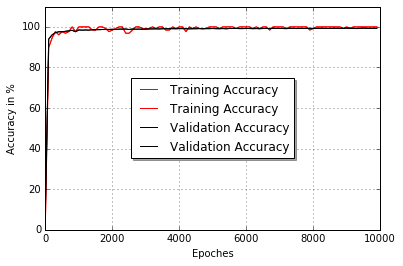

In [31]:
epochs = np.arange(1, n_e, logging_info)
fig, ax = plt.subplots()
#plt.title("Training and validation errors")
plt.xlabel("Epoches")
plt.ylabel("Accuracy in %")
plt.ylim(0,110)
plt.grid()
ax.plot(epochs, model.logger["training_error"], 'r', label='Training Accuracy')
ax.plot(epochs, model.logger["validation_error"], 'k', label='Validation Accuracy')
legend = ax.legend(loc='center', shadow=True)
plt.savefig("../../report/figs/MNIST_SD_Standard.jpg")
plt.show()

# Synthetic Dataset

#### We use the synthetize_data function to create 25000 examples from the MNIST digits. The standard deviation for scaling (a kind of squeezing operation in the OpenCV library, rotation and translation, can here be fixed).

#### We look for sequences of 1 digit only. From this set we use the sklearn function to split into training and testing set. 
#### Since the 11-th digit is the blank character, and we know that there are no such examples in the dataset, in the last two lines we get rid of the last encoding digit for each instance in the training and testing set.

In [59]:
from sklearn.cross_validation import train_test_split

MNIST = mnist.MNIST()
X, y = MNIST.synthetize_data(nb_examples=25000, output_method="one_hot", min_length=1,
                                 max_length=1, scale_std=0.01, center_std=3.0, rotate_std=0.1)

X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
y = y[:,:,:10]
y_test = y_test[:,:,:10]

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


#### First we use the same structure of the previous case. The dataset is sensibly more complicated and we should expect lower testing accuracy

In [60]:
structure = [("conv", {"patch_x": 5, "patch_y": 5, "depth": 32, "channels" : 1}), ("pool", {"side": 2, "stride": 2, "pad": "SAME"}),
                 ("conv", {"patch_x": 5, "patch_y": 5, "depth": 64, "channels": 32}), ("pool", {"side": 2, "stride": 2, "pad": "SAME"})]

model = sdr.Single_Digit_One_Hot(structure=structure, nb_classes=10, img_rows=28, img_cols=28)

In [61]:
n_e = 1000
logging_info = 50
model.fit(X, y, X_test, y_test, batch_size=128,
      nb_epochs=n_e, logging_info=logging_info, seed=0, save_path="MNIST_SD_SYNTHETIC.ckpt")

Minibatch loss value at step 1: 10.93
Current minibatch accuracy: 13.3%
Validation set accuracy: 10.5%
Minibatch loss value at step 51: 1.65
Current minibatch accuracy: 44.5%
Validation set accuracy: 53.4%
Minibatch loss value at step 101: 1.00
Current minibatch accuracy: 64.1%
Validation set accuracy: 74.8%
Minibatch loss value at step 151: 0.99
Current minibatch accuracy: 70.3%
Validation set accuracy: 78.8%
Minibatch loss value at step 201: 0.53
Current minibatch accuracy: 83.6%
Validation set accuracy: 88.0%
Minibatch loss value at step 251: 0.47
Current minibatch accuracy: 86.7%
Validation set accuracy: 89.7%
Minibatch loss value at step 301: 0.30
Current minibatch accuracy: 92.2%
Validation set accuracy: 90.6%
Minibatch loss value at step 351: 0.25
Current minibatch accuracy: 93.8%
Validation set accuracy: 92.3%
Minibatch loss value at step 401: 0.37
Current minibatch accuracy: 87.5%
Validation set accuracy: 92.9%
Minibatch loss value at step 451: 0.35
Current minibatch accuracy:

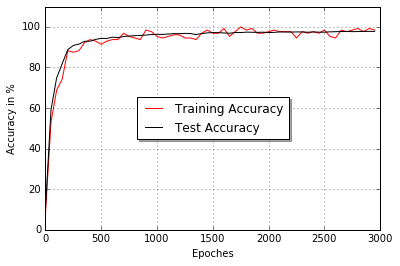

In [10]:
epochs = np.arange(1, n_e, logging_info)

fig, ax = plt.subplots()
plt.xlabel("Epoches")
plt.ylabel("Accuracy in %")
plt.ylim(0,110)
plt.grid()
ax.plot(epochs, model.logger["training_error"], 'r', label='Training Accuracy')
ax.plot(epochs, model.logger["validation_error"], 'k', label='Test Accuracy')
legend = ax.legend(loc='center', shadow=True)
#plt.savefig("../../report/figs/MNIST_SD_Synthetic.jpg")
plt.show()

In [62]:
model.score(X_test, y_test, "MNIST_SD_SYNTHETIC.ckpt")

95.86